In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

#to test for normality
from scipy.stats import shapiro

import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df=pd.read_csv('concrete (1).csv')

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [6]:
df.describe().transpose()
#As checked slag, ash, superplastic have min value as zero.Need to connect with business whether 0 is acceptable value for those attributes or not.
# Assuming that 0 is acceptable for this attributes, we will proceed further. Also for ash and superplastic, median is zero.
#Almost all the independent attributes have no normal distribution and some of them have tails

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [7]:
# no null values
df.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [8]:
# Let us check whether any of the columns has any value other than numeric
df[~df.applymap(np.isreal).all(1)]
#only numeric values are present

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


In [9]:
#lets verify the test of normality using shapiro test
for col in df.columns[0:-1]:
    #print(type(piama_dataset[col]))
    print('Shapiro test result for {} columns is {}'.format(col,shapiro(df[col])))
    
# As seen that for all the columns, we have to reject the null hypothesis and accept alternative hypothesis that independent attributes
#doesn't follows normal distribution

Shapiro test result for cement columns is (0.9589598178863525, 2.0808072415906233e-16)
Shapiro test result for slag columns is (0.8124099373817444, 5.796104035147519e-33)
Shapiro test result for ash columns is (0.7619988918304443, 4.13455134252981e-36)
Shapiro test result for water columns is (0.9803913831710815, 1.4642211054738397e-10)
Shapiro test result for superplastic columns is (0.8660315275192261, 9.066004055146273e-29)
Shapiro test result for coarseagg columns is (0.9824537634849548, 8.352464275773741e-10)
Shapiro test result for fineagg columns is (0.980672299861908, 1.8433758686153823e-10)
Shapiro test result for age columns is (0.5907049179077148, 7.707141553786494e-44)


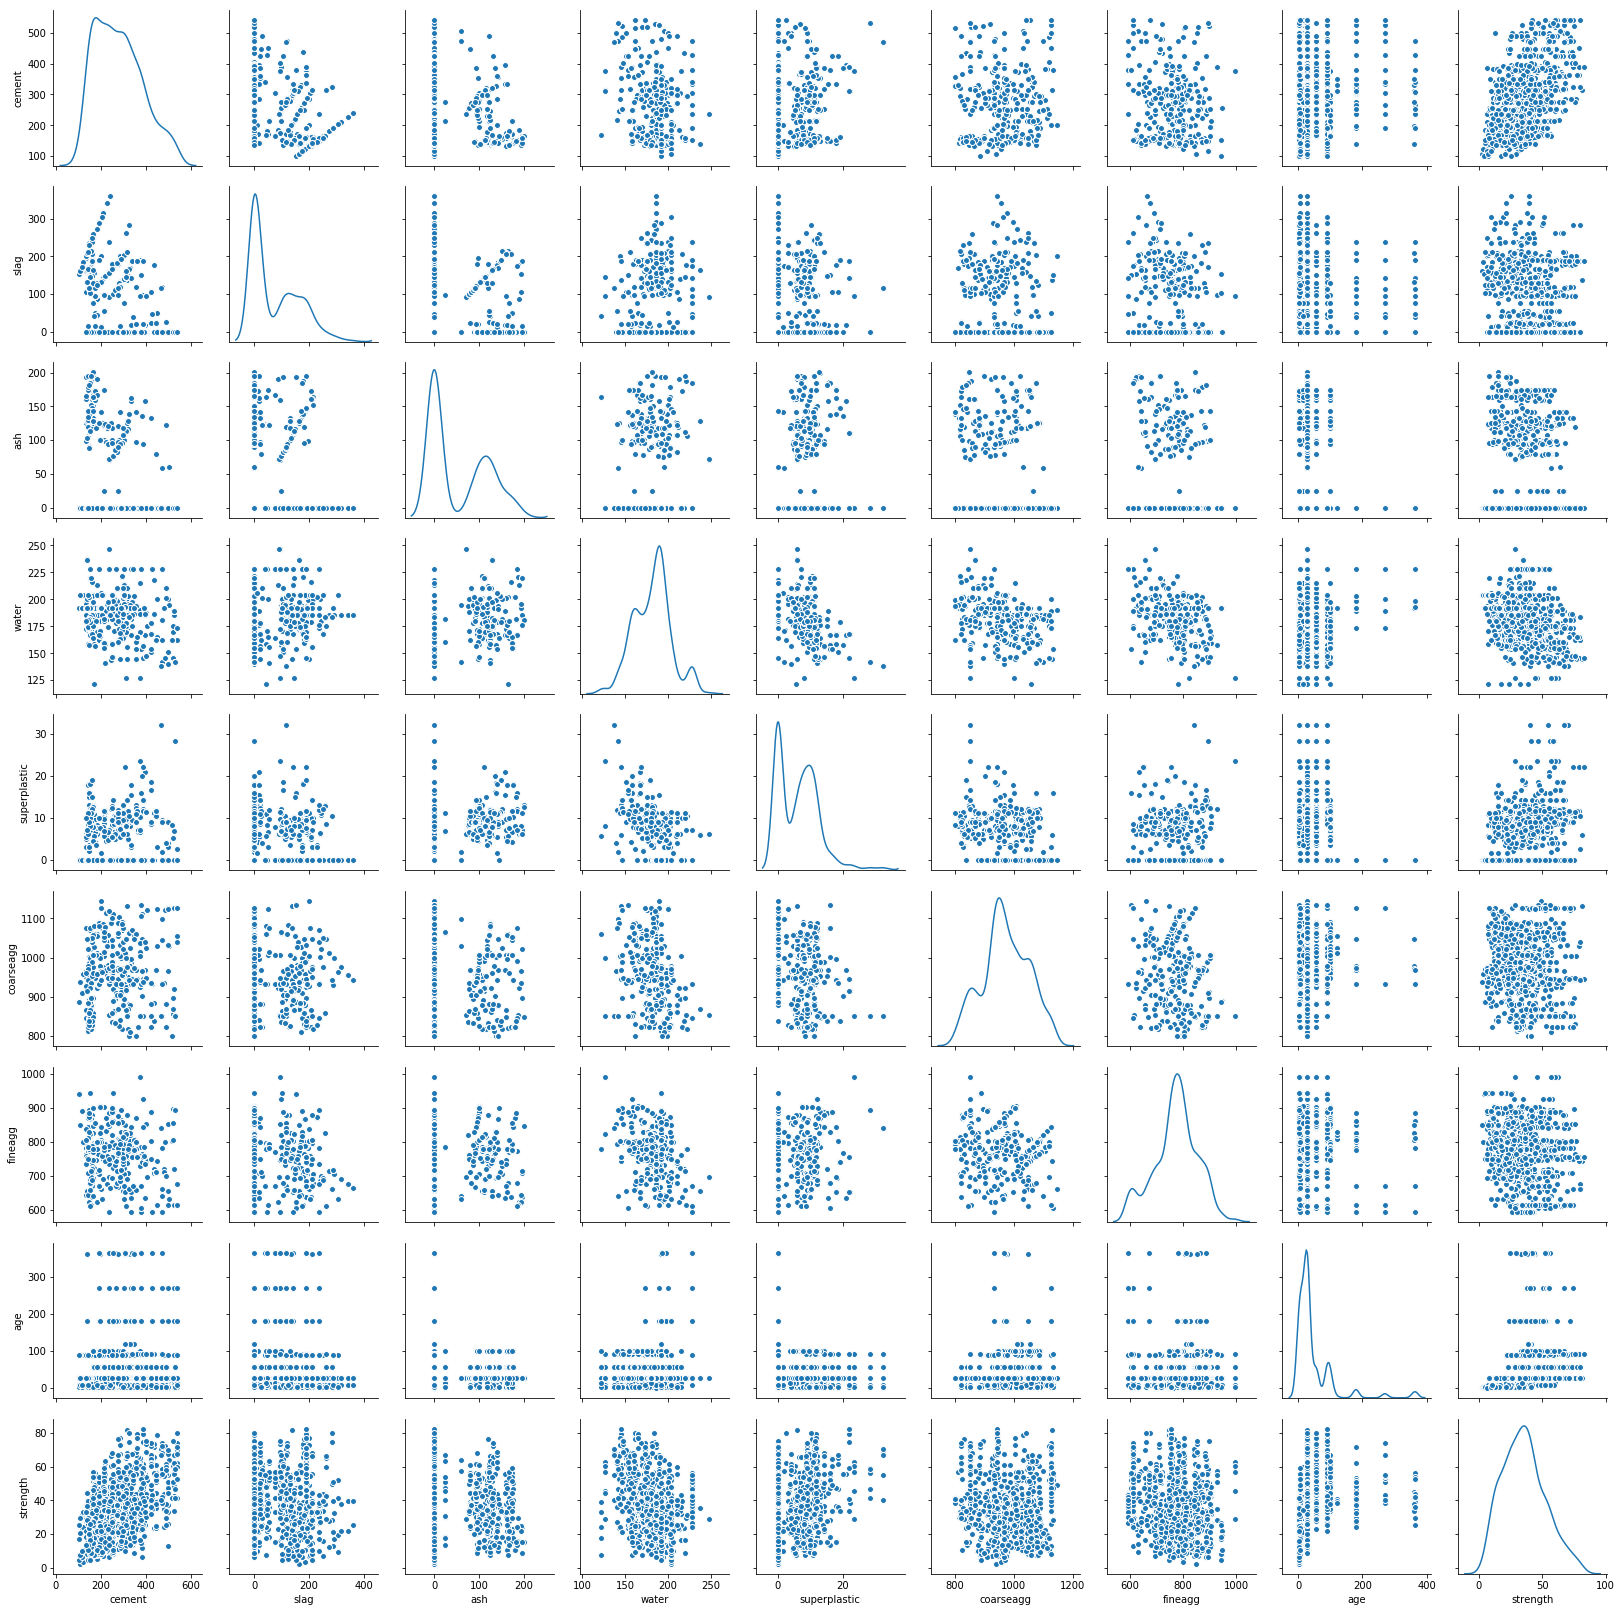

In [10]:
sns.pairplot(df,diag_kind='kde')

As seen from the above pairplot, none of the attribute has stronger corelation with target variable except cement. As the cement quantity increases, strength increases. For slag column, there is no relationship with strength column. For Ash and water column, there exists negative somewhat curvilinear relationship i.e as Ash or water content decreases, strength  of concrete increases.For age attribute, there exists nonlinear relationship with the strength attribute.

In [11]:
#create corelation matrix
cor=df.corr()

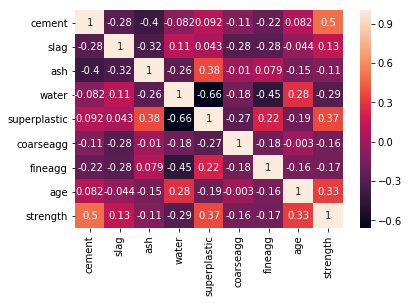

In [13]:
#plot matirx and check the corelation. There exists no strong corelation within the independent attributes and between independent and dependent attribute.
#Only cement has corelation with the target 
sns.heatmap(cor,annot=True)

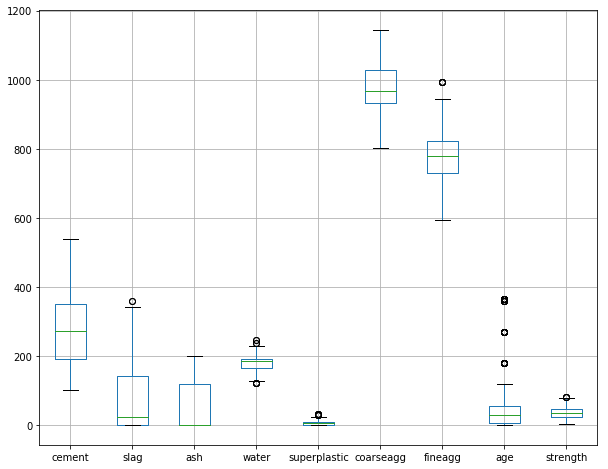

In [15]:
#As we can see from the below boxplot that there are outliers present in slag , water,superplastic,fineagg and age columns
df.boxplot(figsize=(10,8))

In [16]:
#return total number of outliers in a given column
def return_total_numberof_outliers(column):
    q1 = df[column].quantile(0.25) # upper quartile  } Note: The fuction is .quantile() with 'n'
    q3 =df[column].quantile(0.75) # lower quartile  }       not .quartile() with 'r'
    outlier_lower_limit = q1 - 1.5*(q3 - q1)
    outlier_upper_limit = q3 + 1.5*(q3 - q1)
    value=df[column]
    lower_limit_outliers = value[value < outlier_lower_limit].count()
    upper_limit_outliers = value[value > outlier_upper_limit].count()
    print("Total outliers for {} is {}:".format(column,upper_limit_outliers + lower_limit_outliers))


In [19]:
#print number of outlier for all the columns.
#Only age column has comparatively much more number of outliers. Need to check with business for the reason behind the existance of outliers
for column in df.columns[:-1]:
    return_total_numberof_outliers(column)

Total outliers for cement is 0:
Total outliers for slag is 2:
Total outliers for ash is 0:
Total outliers for water is 9:
Total outliers for superplastic is 10:
Total outliers for coarseagg is 0:
Total outliers for fineagg is 5:
Total outliers for age is 59:


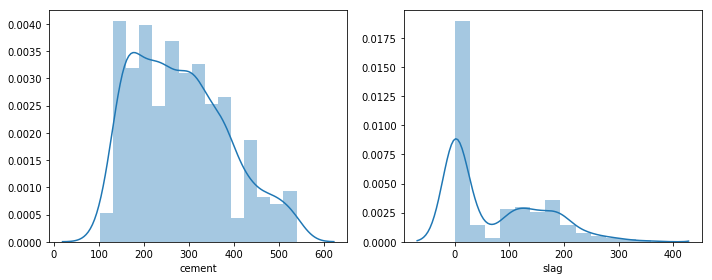

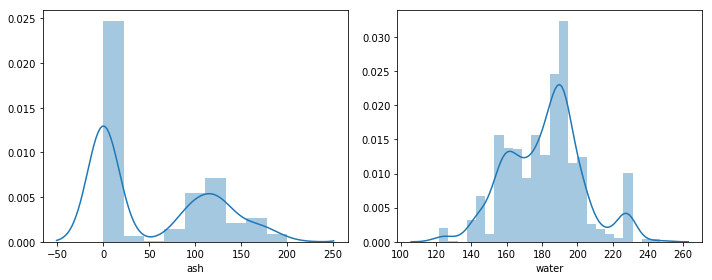

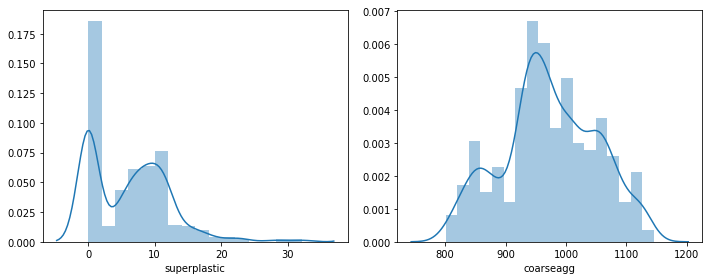

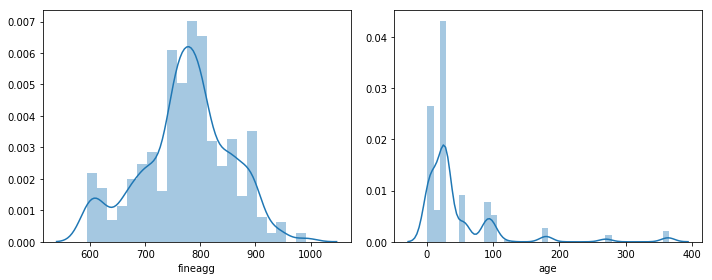

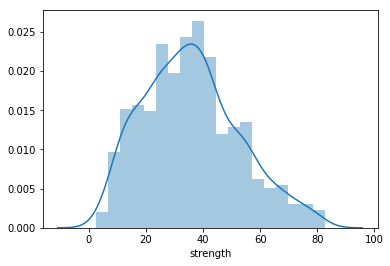

In [21]:
# Histograms
num_cols =['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength']
for i in range(0,len(num_cols),2):
    if len(num_cols) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.distplot(df[num_cols[i]])
        plt.subplot(122)            
        sns.distplot(df[num_cols[i+1]])
        plt.tight_layout()
        plt.show()

    else:
        sns.distplot(df[num_cols[i]])
        
    

In [22]:
#from the above histogram, we can conclude that the attributes are not normally distributed and have multiple peaks in them

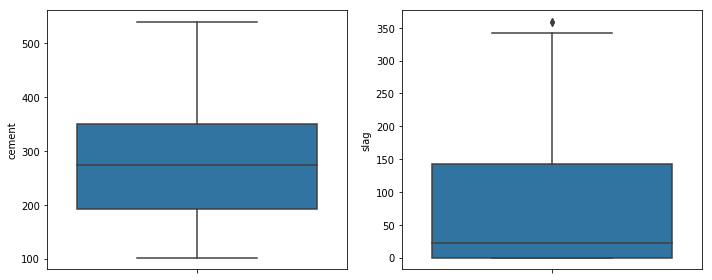

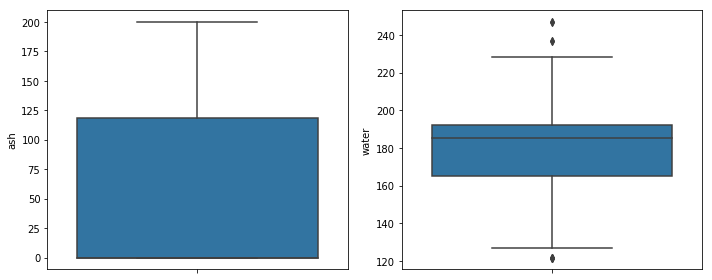

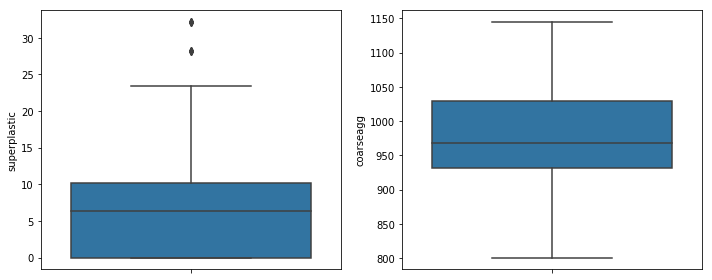

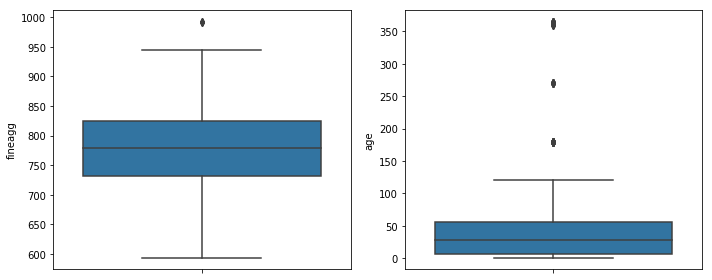

In [23]:
# BoxPlots for outliers

num_cols =['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age']
facet = None
for i in range(0,len(num_cols),2):
    if len(num_cols) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.boxplot(facet, num_cols[i],data = df)
        plt.subplot(122)            
        sns.boxplot(facet, num_cols[i+1],data = df)
        plt.tight_layout()
        plt.show()

    else:
        sns.boxplot(facet, num_cols[i],data = df)


In [24]:
#make copy of original Dataframe
df_copy=df.copy(deep=True)

In [25]:
X = df_copy[df_copy.columns[0:-1]]
X_scaled=X.apply(zscore)
y=df_copy['strength']

In [26]:
#lets create a SVR model
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=seed)
from sklearn.svm import SVR
svr_model=SVR()
svr_model.fit(X_train,y_train)
print(svr_model.score(X_test,y_test))
print(svr_model.score(X_train,y_train))

0.6521334615374916
0.6442437687466162


In [27]:
y_pred=svr_model.predict(X_test)

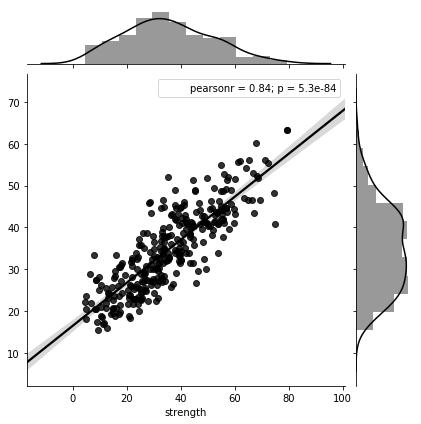

In [28]:
sns.jointplot(x=y_test,y=y_pred,kind='reg',color='k')

In [29]:
# As seen that SVR model doesn't perform well on this dataset.
#let's build an SVR model ponsidering  only superplastic, age, cement, water columns as they have some corelation with the target one
#and check whether there is any performance improvement or not

In [30]:
#lets create a SVR model
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_scaled[['cement','age','superplastic','water']], y, test_size=test_size, random_state=seed)
from sklearn.svm import SVR
svr_model=SVR()
svr_model.fit(X_train_temp,y_train_temp)
print(svr_model.score(X_test_temp,y_test_temp))
print(svr_model.score(X_train_temp,y_train_temp))

0.6256953293860358
0.6381698482549538


In [31]:
# As we can see that building model on selected columns leads to drop in score.

In [32]:
#Lets do some analysis of features using clustering

In [33]:
from sklearn.cluster import KMeans

In [34]:
cluster_range=range(2,10)
errors=[]
for r in cluster_range:
    kmod=KMeans(n_clusters=r,n_init=5)
    kmod.fit(X_scaled)
    labels=kmod.labels_
    centroids=kmod.cluster_centers_
    errors.append(kmod.inertia_)
cluster_df=pd.DataFrame({'no_of_clusters':cluster_range,'cluster_errors':errors})
cluster_df.head(15)

,cluster_errors,no_of_clusters
0,6601.004693,2
1,5659.460800,3
2,4824.437478,4
3,4129.391932,5
4,3659.406717,6
5,3403.724602,7
6,3253.413850,8
7,3051.032849,9


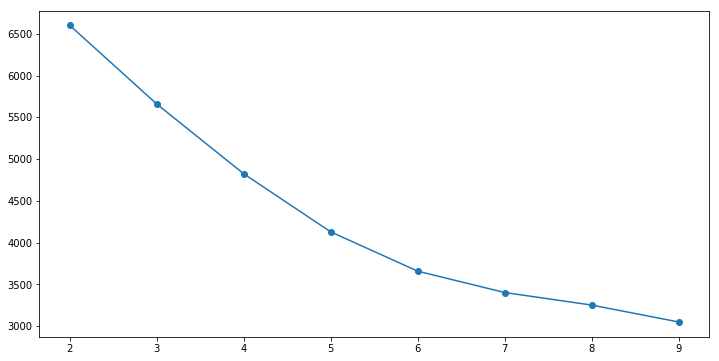

In [35]:
#elbow plot
plt.figure(figsize=(12,6))
plt.plot(cluster_df.no_of_clusters,cluster_df.cluster_errors,marker="o")

In [36]:
#from the above elbow plot we can see that there are likely to be 6 or 7 clusters within the data 
#let's create a model with 6 clusters

In [37]:
cluster_mod=KMeans(n_clusters=6,random_state=6)
cluster_mod.fit(X_scaled)
predictions=cluster_mod.predict(X_scaled)

df_for_kmeans=X_scaled.copy(deep=True)
df_for_kmeans['group']=predictions

In [38]:
centroids=cluster_mod.cluster_centers_
#print cluster centroids
centroids

array([[-0.34361494,  0.17228821,  1.09607803,  0.53178429,  0.39786385,
        -1.21908785, -0.35588934, -0.29177892],
       [ 1.09304283,  0.47859587, -0.58922289, -1.04567898,  1.24985739,
        -0.69861597,  0.34321424, -0.19772525],
       [-0.74827963,  1.35027265, -0.82677072,  0.51256757, -0.62712962,
         0.01339713, -0.2524154 , -0.22421583],
       [ 0.57252903, -0.05946876, -0.84714393,  1.60305321, -1.03914281,
        -0.09367161, -1.21376369,  3.79407891],
       [ 0.70298027, -0.81267512, -0.83832703,  0.48501792, -0.98254961,
         0.58869592, -0.08643264, -0.12870904],
       [-0.58343307, -0.65041892,  1.11317418, -0.63396295,  0.40284101,
         0.58771526,  0.41470313, -0.11269866]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021830D6A128>,
      dtype=object)

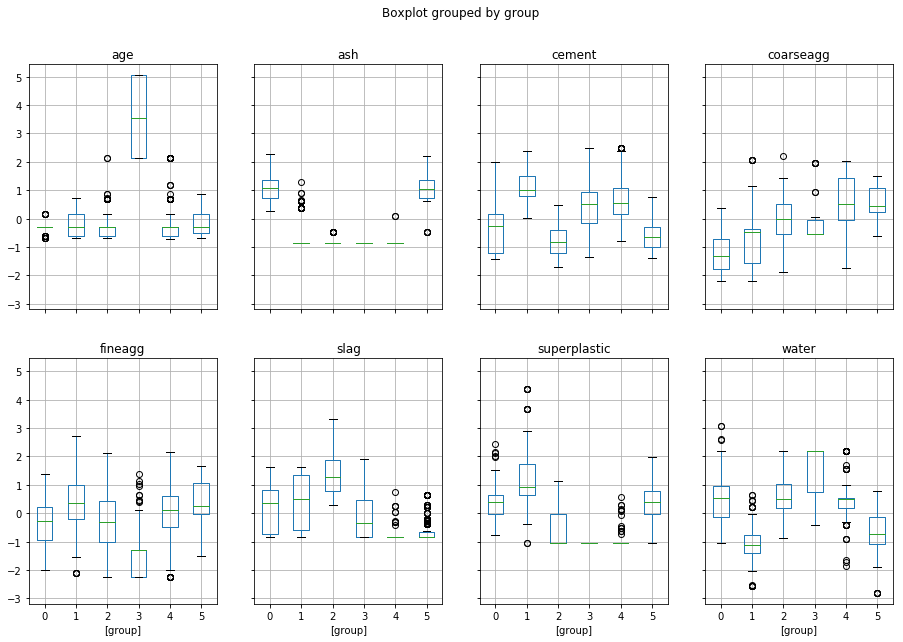

In [39]:
df_for_kmeans.boxplot(by='group',layout=(2,4),figsize=(15,10))

In [43]:
#Only cement, fineagg,water and coarseagg columns have compact clusters within them. Rest all columns have no info 
#in one or the other the cluster. Hence we cannot opt for an approach to have a separate model for each cluster.

In [44]:
#Many outliers are present in most of the dimensions. Lets treat the outliers

def replace_outliers(group):
    median,std=group.median(),group.std()
    outliers=(group-median).abs() > 2*std
    group[outliers]=group.median()
    return group

df_for_kmeans_corrected=(df_for_kmeans.groupby('group').transform(replace_outliers))
concat_data=df_for_kmeans_corrected.join(pd.DataFrame(df_for_kmeans['group']))

C:\Users\cheta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021832E45400>,
      dtype=object)

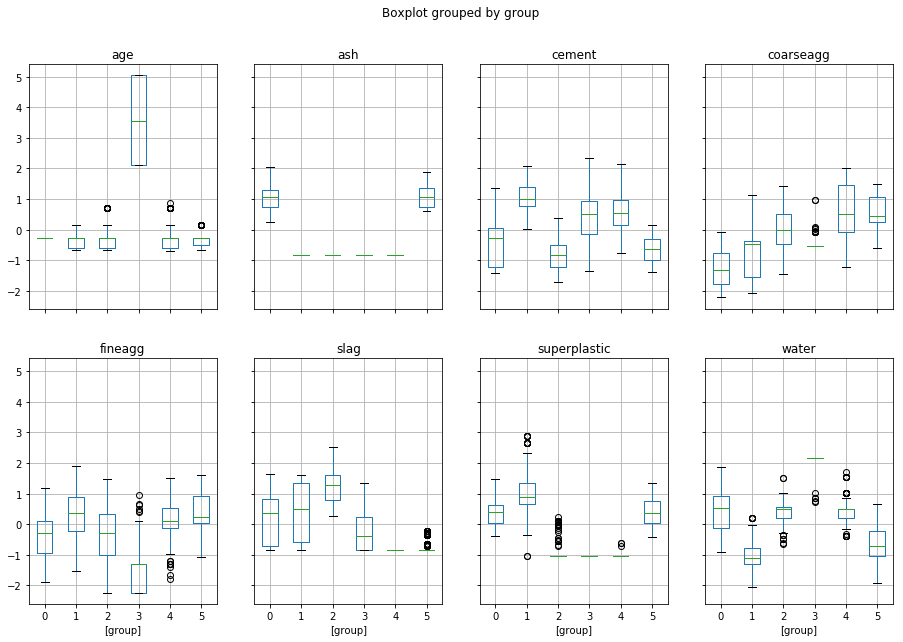

In [45]:
concat_data.boxplot(by='group',layout=(2,4),figsize=(15,10))

In [46]:
#Treating existing outliers give rise to new outliers

In [47]:
#Let's check feature importance and score using decision tree

In [48]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
for i in range(2,9):
    d_model=DecisionTreeRegressor(max_depth=i,min_samples_leaf=6)
    d_model.fit(X_train,y_train)
    print("with max-depth as {}, train score is {} and test score is {}".format(i,d_model.score(X_train,y_train),d_model.score(X_test,y_test)))

with max-depth as 2, train score is 0.48998057022394104 and test score is 0.4645155686954379
with max-depth as 3, train score is 0.631313553801728 and test score is 0.5969859011392976
with max-depth as 4, train score is 0.7358504250642688 and test score is 0.6724696788512221
with max-depth as 5, train score is 0.8070366577254894 and test score is 0.7430624762133726
with max-depth as 6, train score is 0.8590646796030701 and test score is 0.7637655391795931
with max-depth as 7, train score is 0.887496685922985 and test score is 0.802732643307887
with max-depth as 8, train score is 0.900495505886067 and test score is 0.8128448495883209


In [51]:
#As seen from above decision tree model,as max depth increases, model overfitting occurs. At max_depth =2, the score is very low. 
#After considering the score at each depth, decision tree shouldn't be used for modelling on this data set.
#Lets check the feature importance using Decision Tree with max_depth as 4


Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')
[0.41351267 0.05144999 0.         0.13792471 0.0227095  0.
 0.         0.37440313]


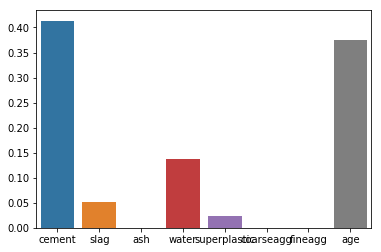

In [59]:
d_model=DecisionTreeRegressor(max_depth=4)
d_model.fit(X_train,y_train)
feature_importance=d_model.feature_importances_
columns=X_scaled.columns
print(columns)
print(feature_importance)
sns.barplot(columns,feature_importance)


In [60]:
#As checked that only cement, water and age are of much more important features.

Let's try to build simple linear regression model without any processing of data

In [61]:
#lets create a SVR model only on selected important columns
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=test_size, random_state=seed)

In [62]:
lr=LinearRegression()

In [63]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
lr.score(X_test,y_test)

0.6228785273568747

In [65]:
#score with the help of simple linear model is not as per expectation.

In [66]:
#lets check the weightages for coefficients
for idx,col in enumerate(X_train.columns):
    print('coefficient for {} is {}'.format(col,lr.coef_[idx]))

coefficient for cement is 11.763466958125136
coefficient for slag is 8.29295500386711
coefficient for ash is 4.6304512758594925
coefficient for water is -3.8132376047666403
coefficient for superplastic is 1.9352383014588344
coefficient for coarseagg is 0.9281759471805912
coefficient for fineagg is 0.5839903871905857
coefficient for age is 7.07619605943484


In [71]:
#creating a ridge model on feature set also gives low score
ridgemodel=Ridge(alpha=0.3)
ridgemodel.fit(X_train,y_train)
print('Train score:')
print(ridgemodel.score(X_train,y_train))
print('Test score:')
print(ridgemodel.score(X_test,y_test))
print('Coeficients:')
print(ridgemodel.coef_)

Train score:
0.6108591368123687
Test score:
0.6226929914085544
Coeficients:
[11.69770095  8.22831506  4.57338234 -3.85469323  1.93738058  0.88350087
  0.52811449  7.07005654]


In [73]:
#creating a ridge model on feature set also gives low score
lassomodel=Lasso(alpha=0.2)
lassomodel.fit(X_train,y_train)
print('Train score:')
print(lassomodel.score(X_train,y_train))
print('Test score:')
print(lassomodel.score(X_test,y_test))
print('Coeficients:')
print(lassomodel.coef_)

Train score:
0.6085130200859561
Test score:
0.6171567817760999
Coeficients:
[10.10651921  6.60559413  3.0414654  -4.41229923  2.08737087 -0.
 -0.43337696  6.71998255]


# Iteration2

In [74]:
#Lets create a set of polynomial features as from the pairplot we can see that non lionear relationship between dependent and independent attributes

In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [77]:
for i in range(2,4):
    poly=PolynomialFeatures(degree=i,interaction_only=True)
    X_poly=poly.fit_transform(X_scaled)
    test_size = 0.30 # taking 70:30 training and test set
    seed = 7  # Random numbmer seeding for reapeatability of the 
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=seed)    
    poly_model=LinearRegression()
    poly_model.fit(X_train,y_train)
    print('Score for degree as {}:'.format(i))
    print('Train score:')
    print(poly_model.score(X_train,y_train))
    print('Test score:')
    print(poly_model.score(X_test,y_test))

Score for degree as 2:
Train score:
0.7596579575557465
Test score:
0.73419151582776
Score for degree as 3:
Train score:
0.8151581813572895
Test score:
0.73934739739393


After creating polynomial features and applying LinearRegression modelscore of the model increased to by almost 10%.
With degree as 3,  model gets overfitted on train set. Lets proceed with degree as 2

In [94]:
poly=PolynomialFeatures(degree=2,interaction_only=True)
X_poly=poly.fit_transform(X_scaled)
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=seed)    
poly_model=LinearRegression()
poly_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
print(poly_model.coef_)

[-3.84050924e-16  1.28445288e+01  9.18506693e+00  5.47276435e+00
 -2.59527721e+00  3.47493206e+00 -2.32739482e-01  7.00619465e-01
  1.43919486e+01  1.65100965e+00  2.13677066e+00 -4.51761144e+00
 -3.91604950e+00  5.27715724e-01  1.31972259e+00  4.50451977e+00
  2.63055462e+00 -2.77270653e+00 -2.70813684e+00 -6.14157142e-01
  2.51130904e+00  5.09843552e+00 -3.23858207e+00 -4.16907023e+00
  5.17135016e-01  2.98219874e+00  7.84988443e+00 -8.72599335e-02
 -1.92831787e+00 -4.95309540e-01 -4.47470961e-01  5.87002466e-02
 -1.46371202e+00  1.93065237e+00  1.17901311e+00  9.59057399e-03
  3.14122419e+00]


In [81]:
#lets apply the ridge model on this PolynomialFeatures set
ridgemodel=Ridge(alpha=0.3,random_state=2)
ridgemodel.fit(X_train,y_train)
print(ridgemodel.score(X_train,y_train))
print(ridgemodel.score(X_test,y_test))

0.759644845079481
0.7343780038284755


In [83]:
#lets apply the ridge model on this PolynomialFeatures set
lassomodel=Lasso(alpha=0.1,random_state=2)
lassomodel.fit(X_train,y_train)
print(lassomodel.score(X_train,y_train))
print(lassomodel.score(X_test,y_test))

0.7494430420173556
0.7399308755400131


In [100]:
#Even after creating, polynomial feature set, we are no were near to target score ie in the range of 85-95%.
#Let's go for complex ensemble models

# Iteration 3

In [116]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [117]:
#lets create a SVR model only on selected important columns
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=test_size, random_state=seed)

In [126]:
#performing Gridsearch CV and find out best parameters for RandomForestRegressor
RF_model=RandomForestRegressor(random_state=42)

param_grid = { 
    'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
    'max_depth' : [4,5,6,7,8]
}

CV_rfc = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print("Best Parameters:")
print(CV_rfc.best_params_)


Best Parameters:
{'max_depth': 8, 'n_estimators': 44}


In [127]:
#Let's build a RandomForestRegressor with maxdepth as 8 and 44 estimators as they are best parameters
RF_model_final=RandomForestRegressor(max_depth=8,n_estimators=44,random_state=42)
RF_model_final.fit(X_train,y_train)
print('Train score:')
print(RF_model_final.score(X_train,y_train))
print('Test score:')
print(RF_model_final.score(X_test,y_test))



Train score:
0.9644517351068479
Test score:
0.9016292436623395


In [132]:
#performing Gridsearch CV and find out best parameters for GradientBoostingRegressor
gdb_reg=GradientBoostingRegressor(random_state=42,learning_rate=0.1)

param_grid = { 
    'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
    'max_depth' : [4,5,6,7,8,9,10]
}

CV_gdb_reg = GridSearchCV(estimator=gdb_reg, param_grid=param_grid, cv= 5)
CV_gdb_reg.fit(X_train, y_train)

print("Best Parameters:")
print(CV_gdb_reg.best_params_)


Best Parameters:
{'max_depth': 5, 'n_estimators': 78}


In [133]:
#Let's build a GradientBoostingRegressor wil maxdepth as 5 and 78 estimators as they are best parameters
gdb_reg_final=GradientBoostingRegressor(max_depth=5,n_estimators=78,random_state=42,learning_rate=0.1)
gdb_reg_final.fit(X_train,y_train)
print('Train score:')
print(gdb_reg_final.score(X_train,y_train))
print('Test score:')
print(gdb_reg_final.score(X_test,y_test))



Train score:
0.9816131720601484
Test score:
0.9288674761462189


In [135]:
#performing Gridsearch CV and find out best parameters for BaggingRegressor
bag_reg=BaggingRegressor(random_state=42,oob_score=True)

param_grid = { 
    'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

CV_bag_reg = GridSearchCV(estimator=bag_reg, param_grid=param_grid, cv= 5)
CV_bag_reg.fit(X_train, y_train)

print("Best Parameters:")
print(CV_bag_reg.best_params_)


C:\Users\cheta\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\cheta\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\cheta\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\cheta\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("So

Best Parameters:
{'max_samples': 0.5, 'n_estimators': 48}


In [136]:
#Let's build a BaggingRegressor with n_estimators  as 48 and max_samples as 0.5 as they are best parameters
bag_reg_final=BaggingRegressor(random_state=42,oob_score=True,n_estimators=48,max_samples=0.5)
bag_reg_final.fit(X_train,y_train)
print('Train score:')
print(bag_reg_final.score(X_train,y_train))
print('Test score:')
print(bag_reg_final.score(X_test,y_test))



Train score:
0.9539559110295265
Test score:
0.8955993717578811


In [137]:
#Using simple models and creating polynomial features didn't helped in getting the score in the range of 85%-95%.
#After using complex models, we are able to achieve a score above 90%.
#Hence from the above complex models, we can use either Randomforest Regressor or BaggingRegressor or GradientBosstingRegressor
#to attain a score in the range of 85 % to 95 % with the best param values selected.